# 2. ConvNet

In [1]:
import os
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mxnet as mx
## Python version
print(sys.version)

2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]


In [3]:
mx.__version__

'0.11.0'

In [4]:
home_dir = "/home/ubuntu/Notebooks/HeadPose110817"

In [5]:
import pickle

os.chdir(home_dir)
trn_im, test_im, trn_output, test_output = pickle.load(open( "HeadPose_trn_test_111317_ReduBy4_py2.pkl", "rb" ))

In [7]:
print([trn_im.shape, test_im.shape, trn_output.shape, test_output.shape])
print(trn_output[4,:])
print([np.max(trn_im), np.min(trn_im)])

[(2232, 3, 72, 96), (558, 3, 72, 96), (2232, 2), (558, 2)]
[-0.66666669  0.        ]
[1.0, 0.027450981]


In [13]:
batch_size = 200

## label_name = 'lin_reg_label', otherwise it automatically sets to be softmax_label
trn_iter = mx.io.NDArrayIter((trn_im.astype(np.float32) - 0.5) * 2, trn_output.astype(np.float32), batch_size, shuffle=True, label_name='lin_reg_label')
test_iter = mx.io.NDArrayIter((test_im.astype(np.float32) - 0.5) * 2, test_output.astype(np.float32), batch_size)

#trn_iter.__dict__

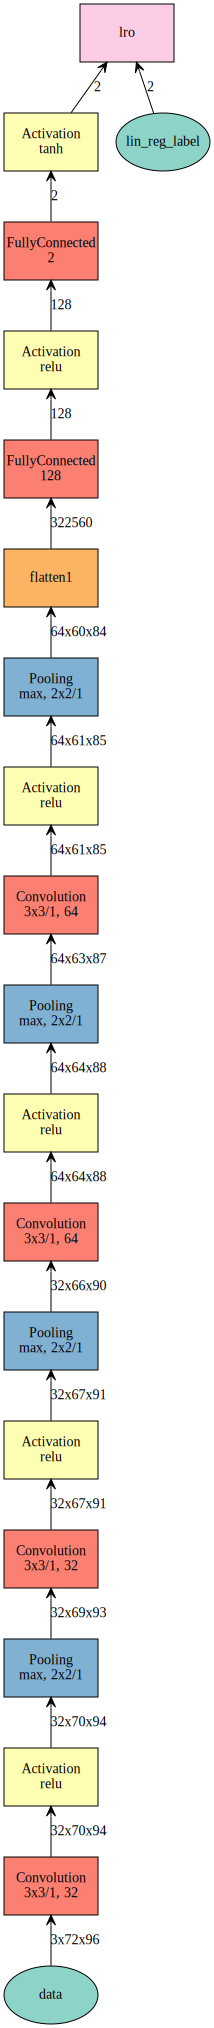

In [14]:
#Model

data = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
#mxnet.symbol.Convolution(data=None, weight=None, bias=None, kernel=_Null, stride=_Null, dilate=_Null, pad=_Null, num_filter=_Null, num_group=_Null, workspace=_Null, no_bias=_Null, cudnn_tune=_Null, cudnn_off=_Null, layout=_Null, name=None, attr=None, out=None, **kwargs)¶

# https://github.com/laodar/cnn_head_pose_estimator
# conv 1 layer
conv1 = mx.sym.Convolution(data=data, kernel=(3,3), num_filter=32)
act1 = mx.sym.Activation(data=conv1, act_type='relu')
pool1 = mx.sym.Pooling(data=act1, pool_type="max", kernel=(2,2))

# conv 2 layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(3,3), num_filter=32)
act2 = mx.sym.Activation(data=conv2, act_type='relu')
pool2 = mx.sym.Pooling(data=act2, pool_type="max", kernel=(2,2))

# conv 3 layer
conv3 = mx.sym.Convolution(data=pool2, kernel=(3,3), num_filter=64)
act3 = mx.sym.Activation(data=conv3, act_type='relu')
pool3 = mx.sym.Pooling(data=act3, pool_type="max", kernel=(2,2))

# conv 4 layer ###
conv4 = mx.sym.Convolution(data=pool3, kernel=(3,3), num_filter=64)
act4 = mx.sym.Activation(data=conv4, act_type='relu')
pool4 = mx.sym.Pooling(data=act4, pool_type="max", kernel=(2,2))


# Fully connected layer
flatten = mx.sym.Flatten(pool4)
fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=128)
act_f1 = mx.sym.Activation(data=fc1, act_type='relu')

fc2 = mx.sym.FullyConnected(data=act_f1, num_hidden=2)
act_f2 = mx.sym.Activation(data=fc2, act_type='tanh')

lro = mx.sym.LinearRegressionOutput(data=act_f2, label=Y, name="lro")


# Output layer

shape = {"data": (batch_size, 3, 72, 96)}
mx.viz.plot_network(lro, shape=shape)

In [15]:
print(trn_iter.provide_data[0], trn_iter.provide_label[0])

(DataDesc[data,(200, 3L, 72L, 96L),<type 'numpy.float32'>,NCHW], DataDesc[lin_reg_label,(200, 2L),<type 'numpy.float32'>,NCHW])


In [16]:
# Train the model

import logging
logging.getLogger().setLevel(logging.DEBUG)

ctx = [mx.gpu(i) for i in range(2)]
#ctx = mx.cpu()
num_epoch = 50

net = mx.mod.Module(symbol=lro, 
                    data_names=['data'],
                    label_names = ['lin_reg_label'],
                    context=ctx)

#net = mx.mod.Module(symbol=lro,context=ctx)

net.bind(data_shapes=[trn_iter.provide_data[0]], label_shapes=[trn_iter.provide_label[0]])

net.fit(trn_iter,
       test_iter,
       optimizer="sgd",
       optimizer_params={'learning_rate' : 2},
       eval_metric='mse',
       batch_end_callback=mx.callback.Speedometer(batch_size, 200),
       num_epoch=num_epoch
       )

#https://mxnet.incubator.apache.org/tutorials/python/linear-regression.html

INFO:root:Epoch[0] Train-mse=0.282096
INFO:root:Epoch[0] Time cost=3.648
INFO:root:Epoch[0] Validation-mse=0.288765
INFO:root:Epoch[1] Train-mse=0.282044
INFO:root:Epoch[1] Time cost=3.048
INFO:root:Epoch[1] Validation-mse=0.288762
INFO:root:Epoch[2] Train-mse=0.282042
INFO:root:Epoch[2] Time cost=3.050
INFO:root:Epoch[2] Validation-mse=0.288760
INFO:root:Epoch[3] Train-mse=0.282040
INFO:root:Epoch[3] Time cost=3.033
INFO:root:Epoch[3] Validation-mse=0.288759
INFO:root:Epoch[4] Train-mse=0.282040
INFO:root:Epoch[4] Time cost=3.036
INFO:root:Epoch[4] Validation-mse=0.288759
INFO:root:Epoch[5] Train-mse=0.282040
INFO:root:Epoch[5] Time cost=3.035
INFO:root:Epoch[5] Validation-mse=0.288759
INFO:root:Epoch[6] Train-mse=0.282040
INFO:root:Epoch[6] Time cost=3.035
INFO:root:Epoch[6] Validation-mse=0.288759
INFO:root:Epoch[7] Train-mse=0.282040
INFO:root:Epoch[7] Time cost=3.037
INFO:root:Epoch[7] Validation-mse=0.288759
INFO:root:Epoch[8] Train-mse=0.282040
INFO:root:Epoch[8] Time cost=3.040

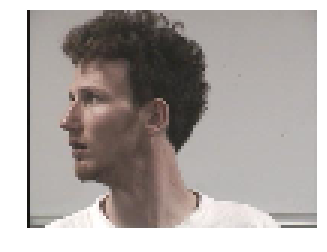

[ 2.86724854  5.20102978]


In [46]:
# prediction function

idx = 30; 
plt.imshow(np.transpose(test_im[idx], (1,2,0))[:,:,[2,1,0]])
plt.axis('off')
plt.show()

preds = net.predict(test_iter)
prob = preds[idx].asnumpy()

print(prob * 90)

In [47]:
print(trn_output[idx] * 90)

[-90.   0.]
